In [26]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import display

from disruption_survival_analysis.sweep_config import create_experiment_groups, get_experiments


from disruption_survival_analysis.plot_experiments import plot_auroc_timeslice_all_vs_horizon
from disruption_survival_analysis.plot_experiments import plot_false_alarm_rate_vs_threshold, plot_threshold_vs_false_alarm_rate, plot_auroc_timeslice_shot_avg_vs_horizon, plot_warning_time_vs_false_alarm_rate, plot_roc_curve, plot_warning_time_vs_threshold
from disruption_survival_analysis.plot_experiments import plot_risk_compare_models, plot_ettd_compare_models
from disruption_survival_analysis.plot_experiments import plot_disruptive_vs_non_disruptive_shot_durations

device = 'synthetic'
dataset_path = 'test'
#device = 'cmod'
#dataset_path = 'preliminary_dataset_no_ufo'

# models, alarms, metrics, and minimum warning times to use
models = ['dsm']
alarms = ['hyst']
metrics = ['auroc']
min_warning_times = [0.1]

# Load models and create experiments
experiment_groups = create_experiment_groups(device, dataset_path, models, alarms, metrics, min_warning_times)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for synthetic/test/dsm_hyst_auroc_100ms.yaml
---
Loaded model from models/synthetic/test/dsm_hyst_auroc_100ms.pkl


## Micro Average ROC AUC vs Horizon

See how the models perform at the individual timeslice level across the entire database.

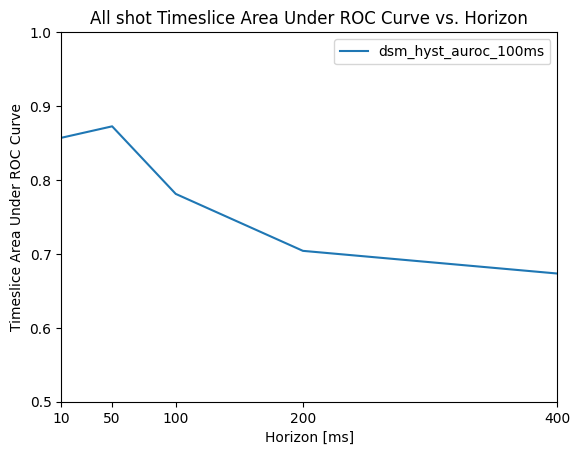

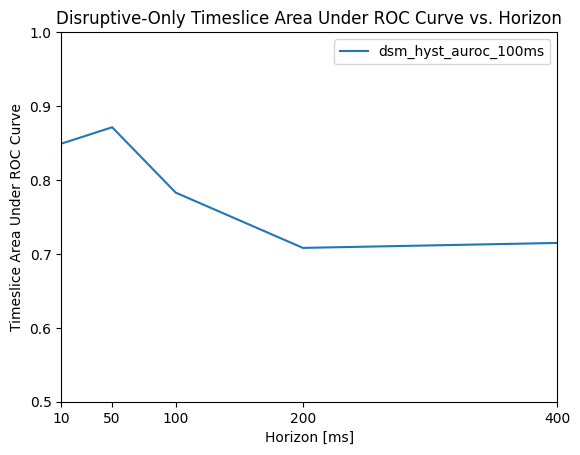

In [27]:
experiment_list = get_experiments(experiment_groups, ['dsm', 'hyst', 'auroc'])
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=False)
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=True)


## Table of Metrics:

In [28]:
required_warning_time = 0.1

result_data = []
for experiment in experiment_list:
    auroc = experiment.evaluate_metric('auroc', required_warning_time=required_warning_time)
    auwtc = experiment.evaluate_metric('auwtc', required_warning_time=required_warning_time)
    maxf1 = experiment.evaluate_metric('maxf1', required_warning_time=required_warning_time)
    tar, far, avg_warn, std_warn = experiment.max_f1_info(required_warning_time=required_warning_time)
    
    result_array = [experiment.name, auroc, auwtc*1000, maxf1, tar, far, avg_warn*1000, std_warn*1000]
    result_data.append(result_array)
    
result_df = pd.DataFrame(result_data, columns=['Experiment Name', 'AUROC', 'AUWTC', 'Max F1', 'TAR', 'FAR', 'Avg. Warn [ms]', 'Std. Warn [ms]'])
print(f"Model Performance when Reqired Warning Time is {required_warning_time*1000} ms")
display(result_df)

Model Performance when Reqired Warning Time is 100.0 ms


,Experiment Name,AUROC,AUWTC,Max F1,TAR,FAR,Avg. Warn [ms],Std. Warn [ms]
0,dsm_hyst_auroc_100ms,0.174194,29.016783,0.243902,1.0,1.0,752.730353,167.544663


## ROC Curve

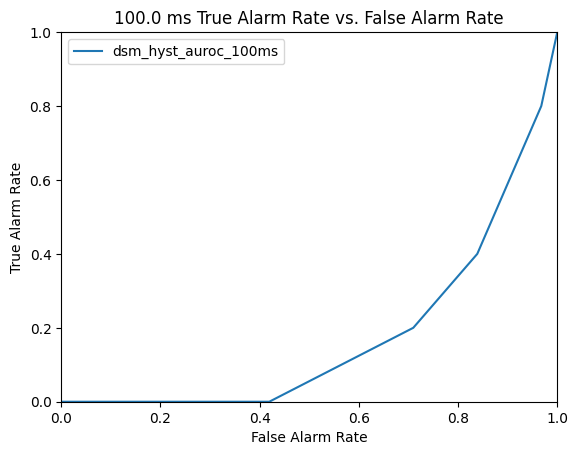

In [32]:
plot_roc_curve(experiment_list, required_warning_time=required_warning_time)

## Area Under Warning Time Curve



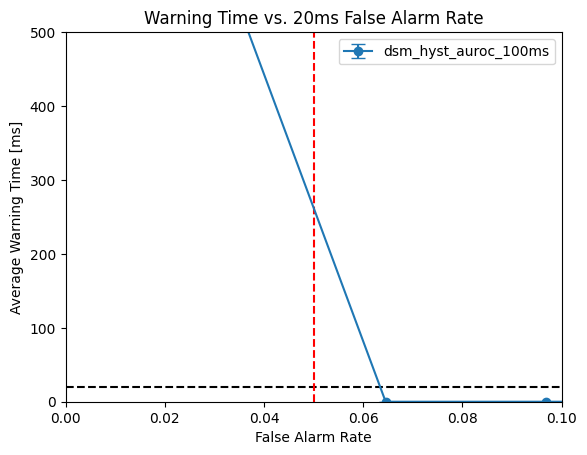

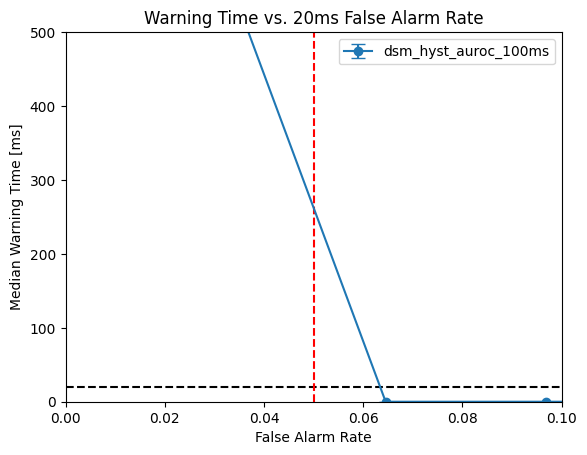

In [31]:
plot_warning_time_vs_false_alarm_rate(experiment_list, cutoff_far=0.05, method='average')
plot_warning_time_vs_false_alarm_rate(experiment_list, cutoff_far=0.05, method='median')

## Warning Time vs. Threshold

c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\plot_experiments.py:209: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([min_threshold, max_threshold])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping hysteresis alarm times for warning time vs. threshold plot
Skipping hysteresis alarm times for warning time vs. threshold plot
Skipping hysteresis alarm times for warning time vs. threshold plot
Skipping hysteresis alarm times for warning time vs. threshold plot


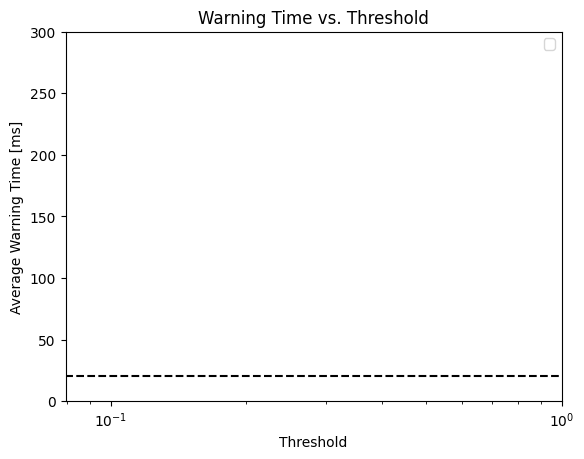

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping hysteresis alarm times for warning time vs. threshold plot
Skipping hysteresis alarm times for warning time vs. threshold plot
Skipping hysteresis alarm times for warning time vs. threshold plot
Skipping hysteresis alarm times for warning time vs. threshold plot


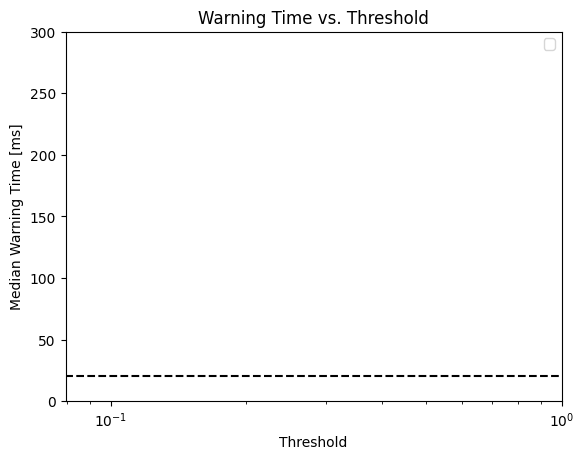

In [6]:
plot_warning_time_vs_threshold(experiment_list, cutoff_far=0.05, method='average')
plot_warning_time_vs_threshold(experiment_list, cutoff_far=0.05, method='median')

## False Positive Rate vs. Threshold

Skipping hysteresis alarm times for false alarm rate vs. threshold plot
Skipping hysteresis alarm times for false alarm rate vs. threshold plot


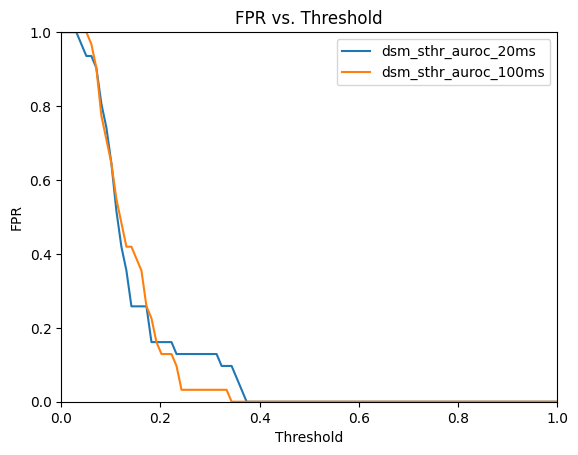

Skipping hysteresis alarm times for threshold vs. false alarm rate plot
Skipping hysteresis alarm times for threshold vs. false alarm rate plot


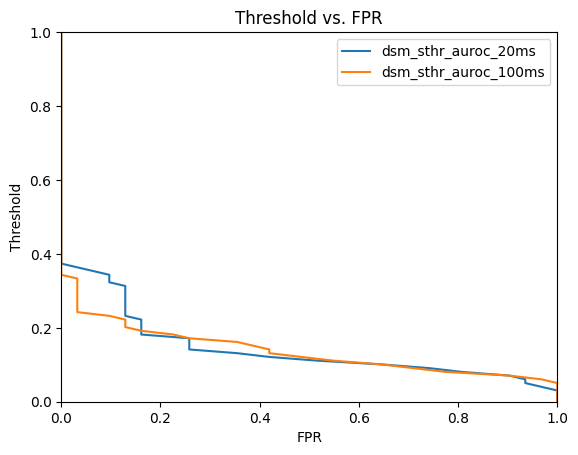

In [25]:
plot_false_alarm_rate_vs_threshold(experiment_list, cutoff_far=0.05, method='average')
plot_threshold_vs_false_alarm_rate(experiment_list, cutoff_far=0.05, method='average')

## Model Output plotted over time

Dotted line is the hyperparameter horizon / class time. (How far before the disruption the model should start to 'see' it coming)

Solid line is required warning time.

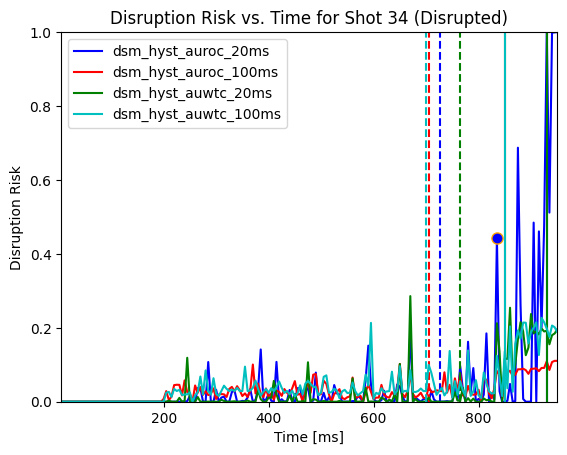

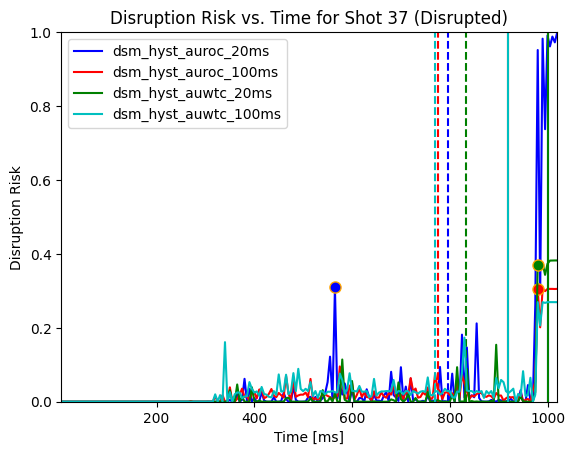

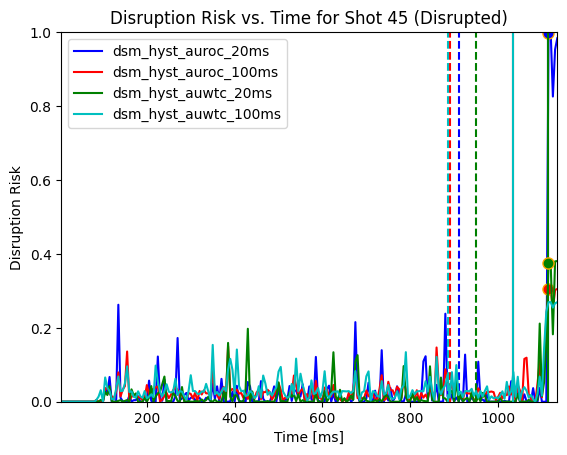

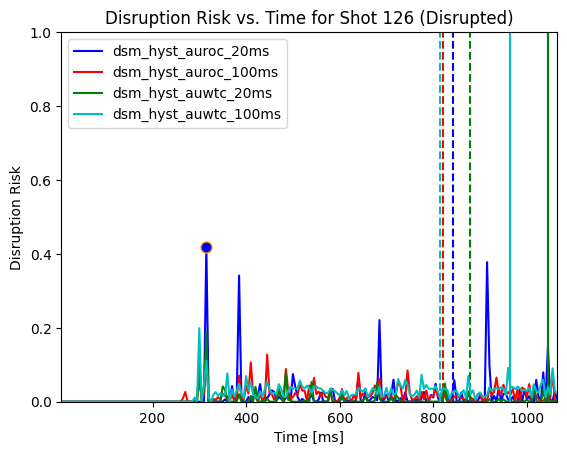

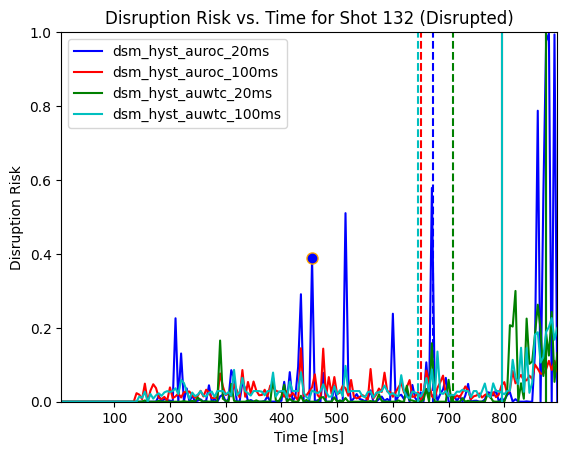

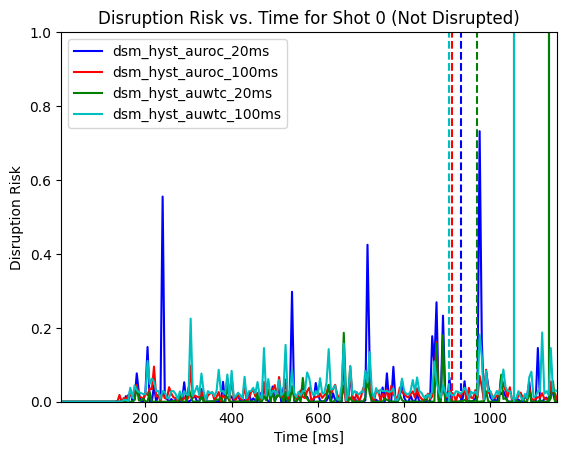

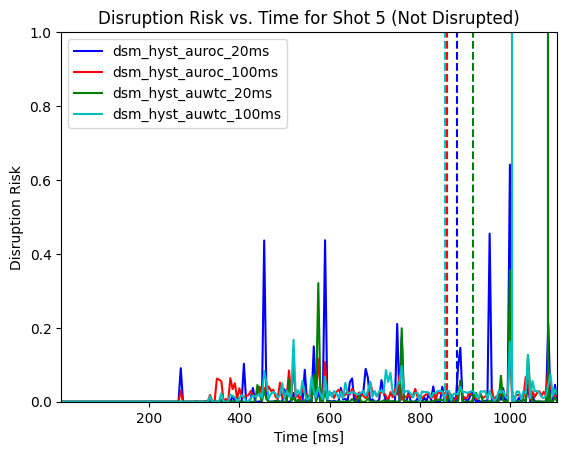

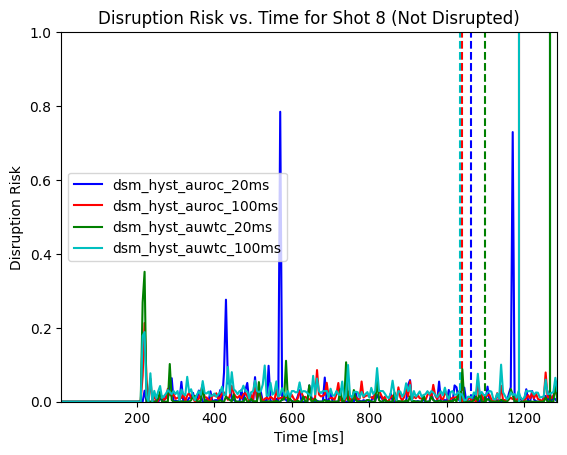

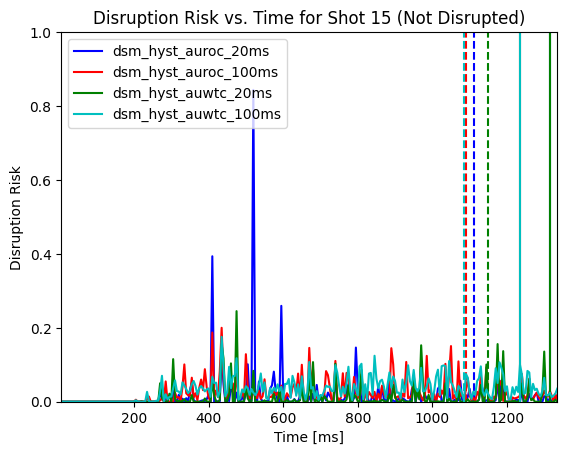

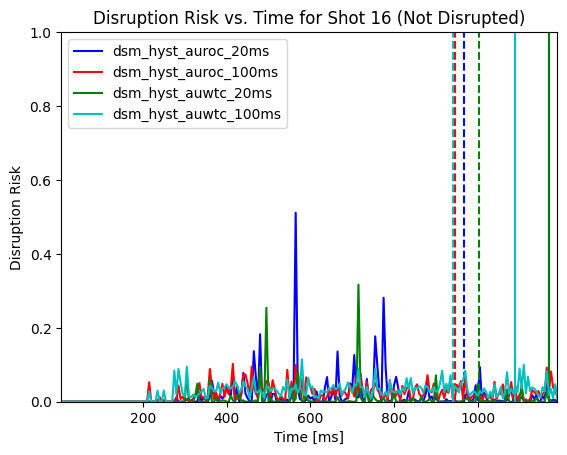

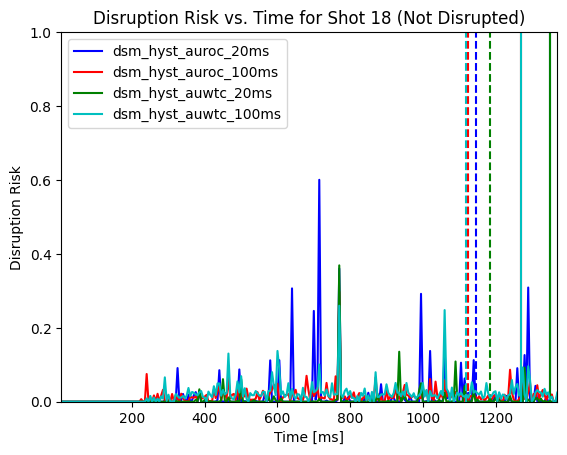

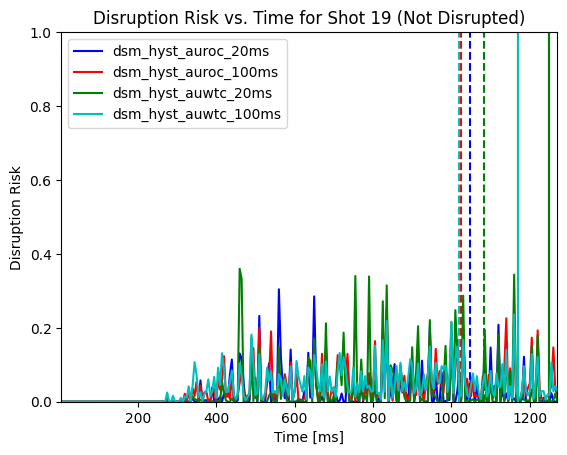

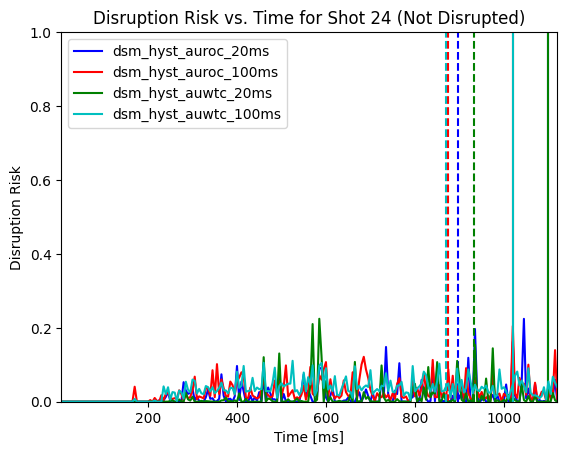

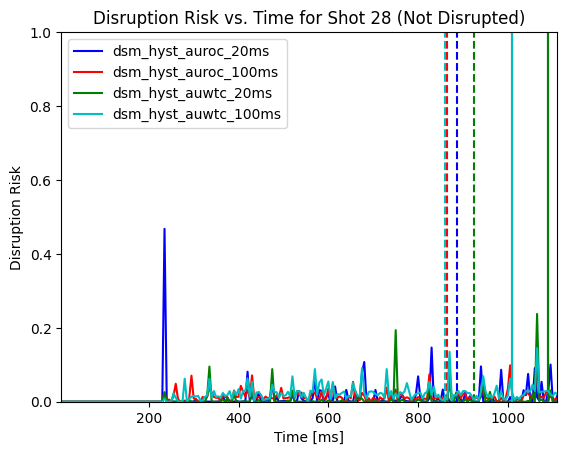

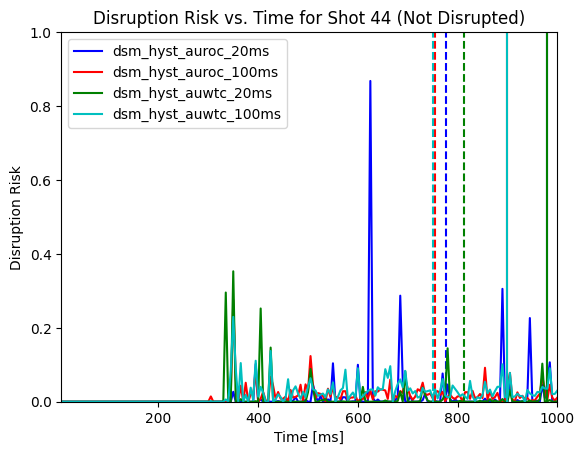

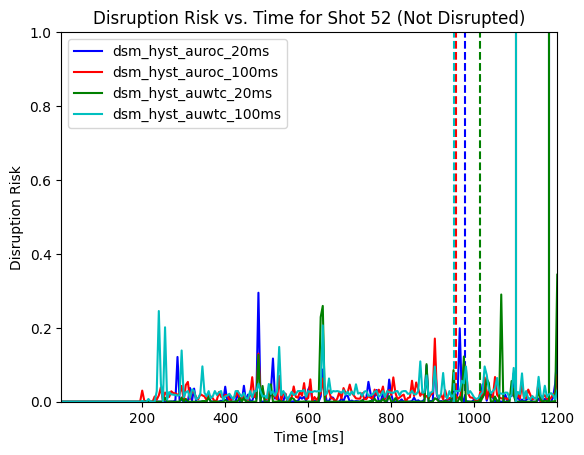

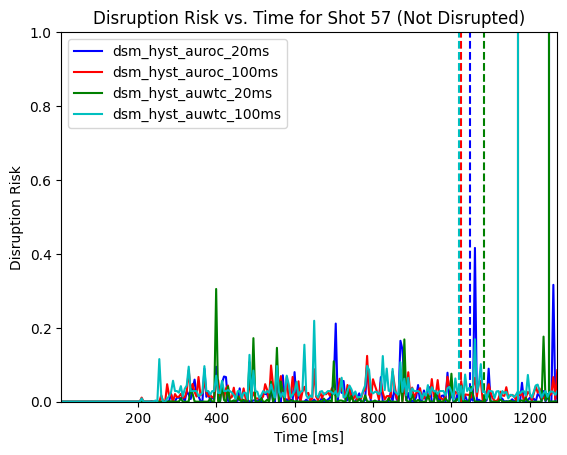

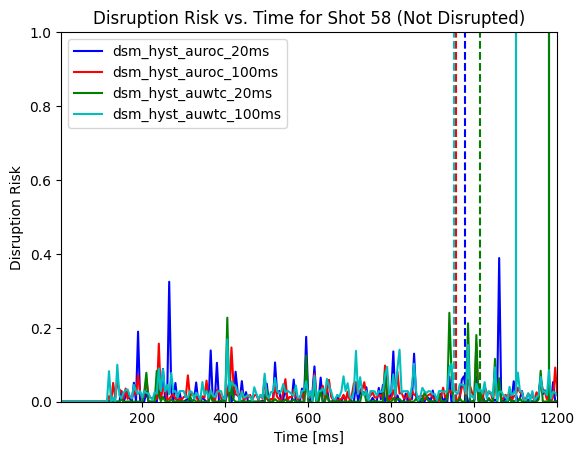

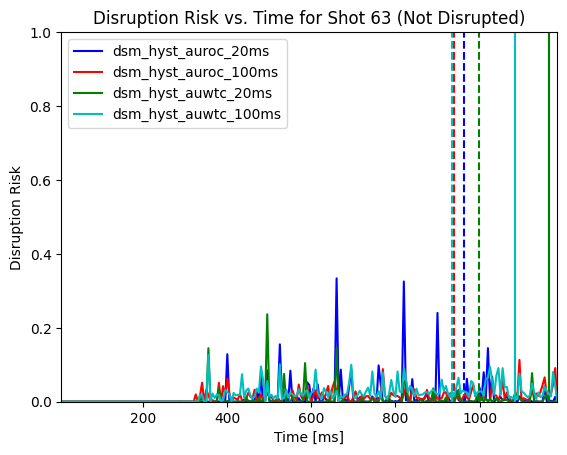

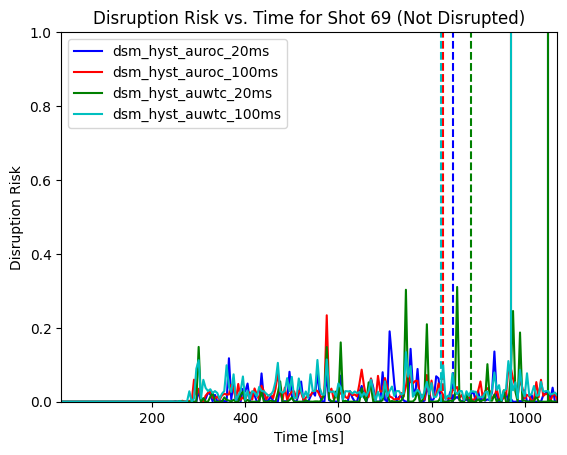

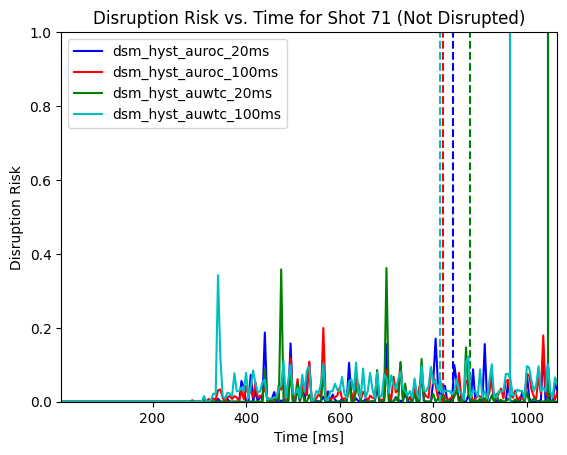

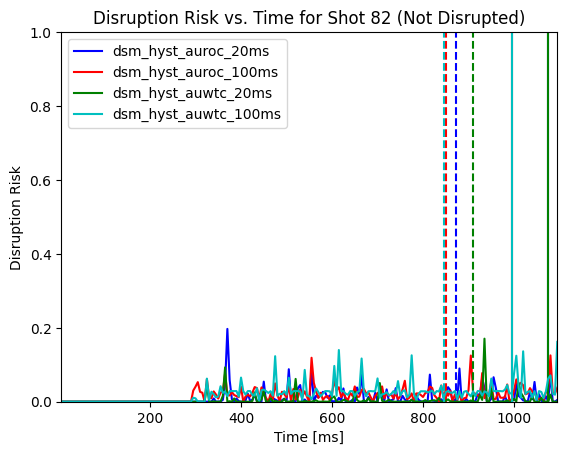

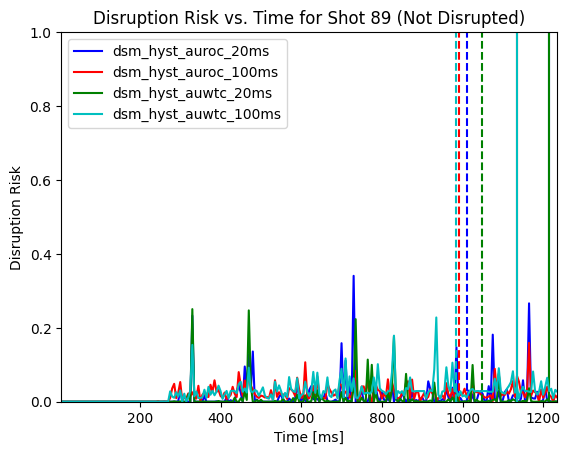

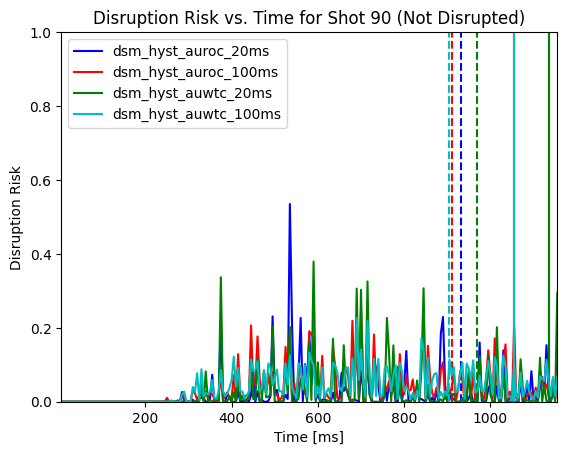

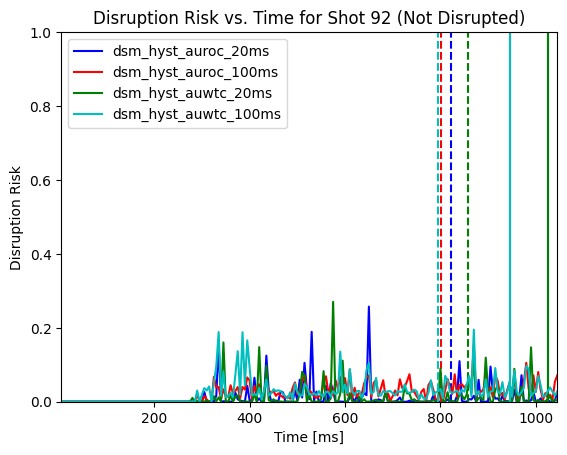

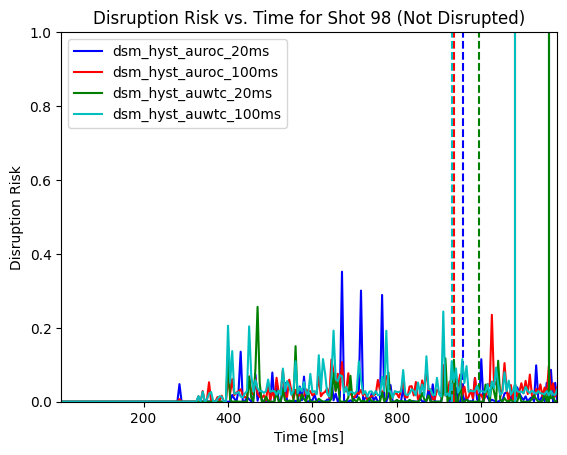

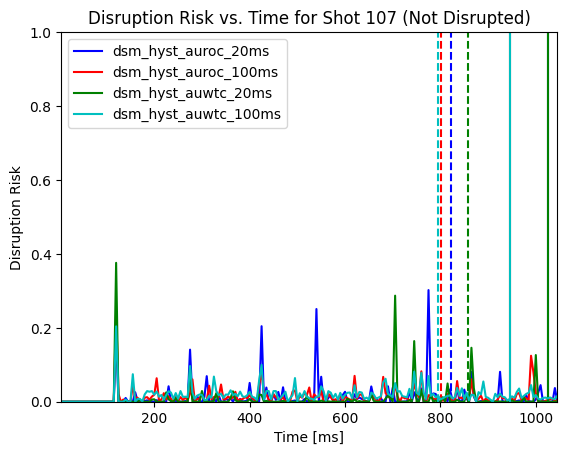

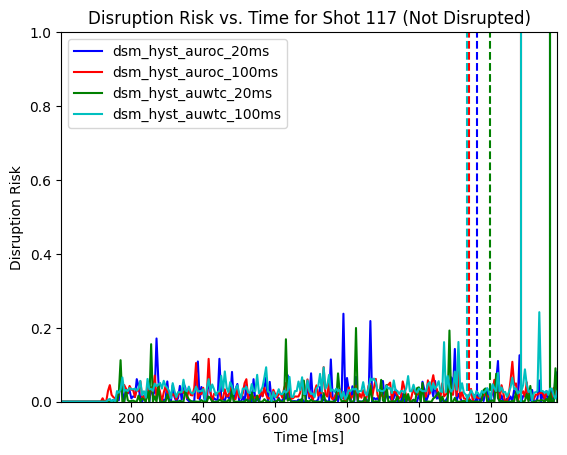

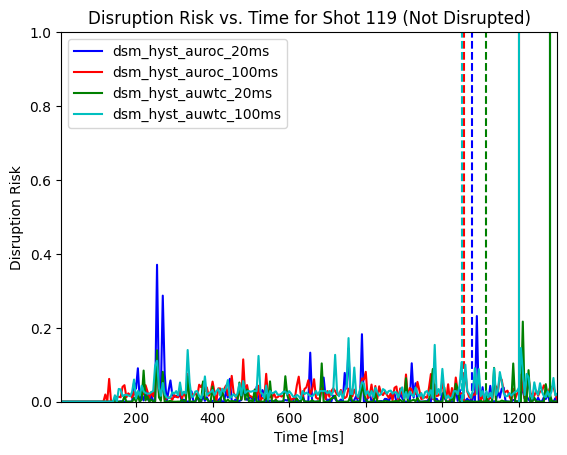

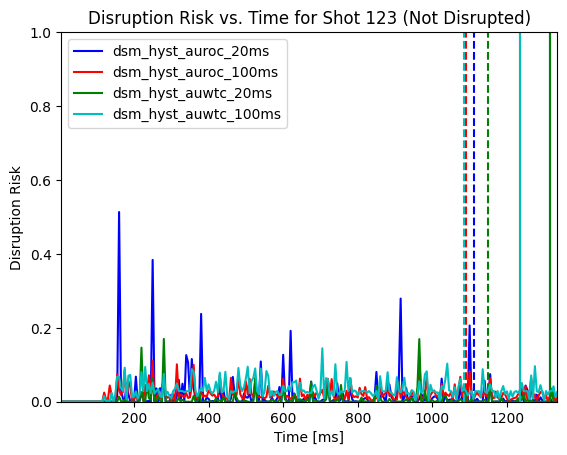

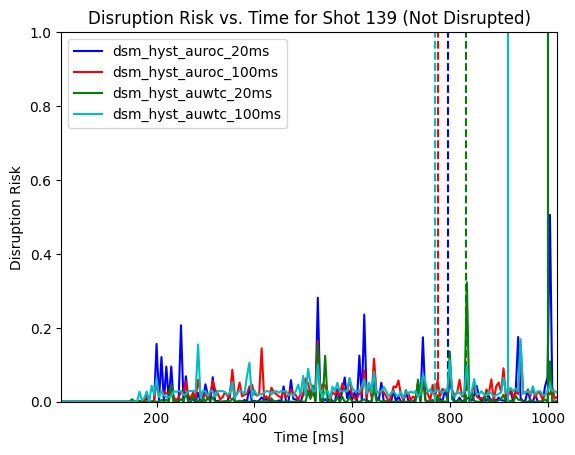

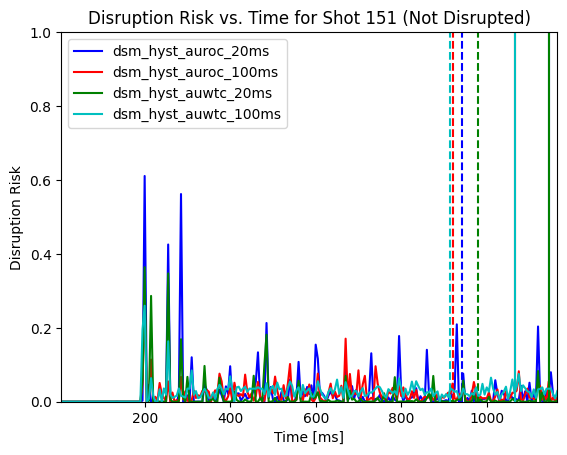

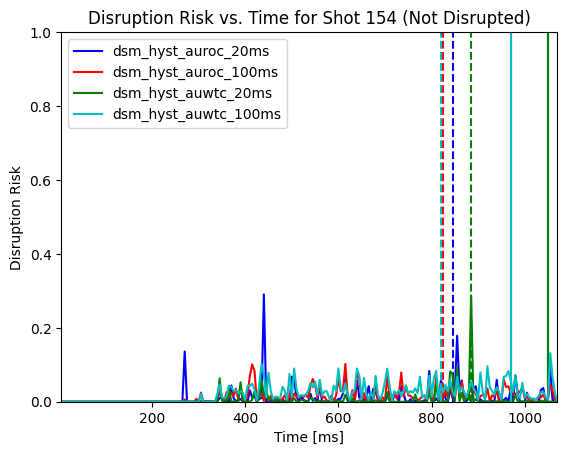

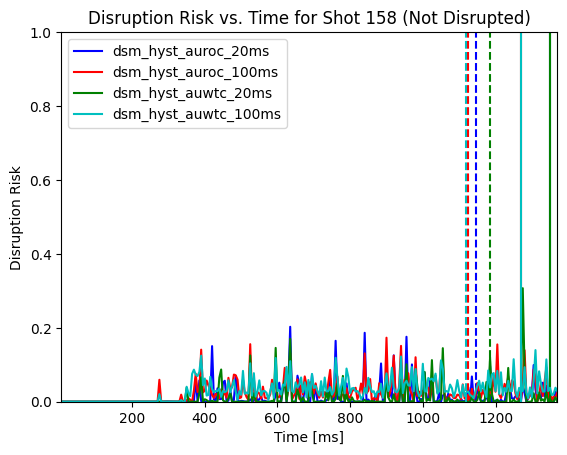

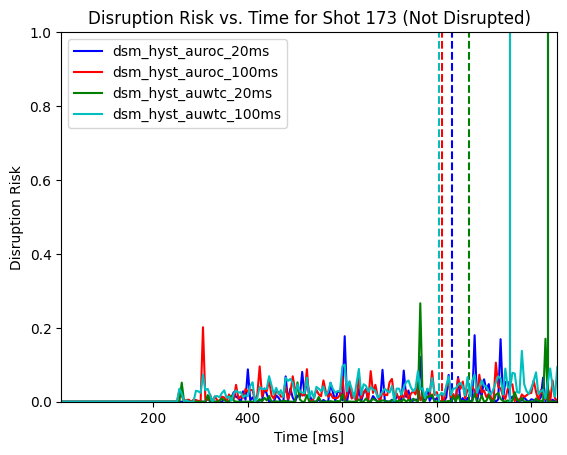

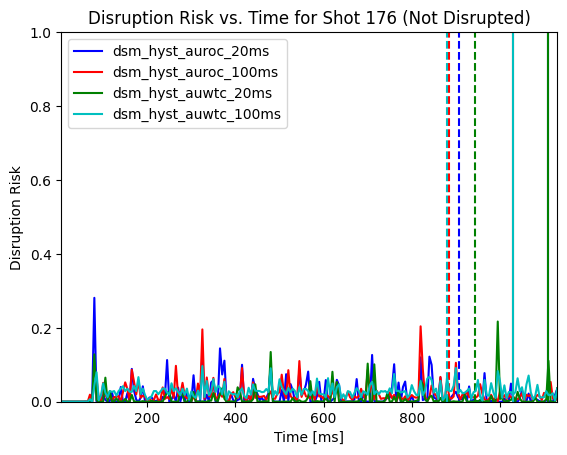

In [15]:
for shot_number in experiment_list[0].get_disruptive_shot_list():
    plot_risk_compare_models(experiment_list, shot_number, threshold=(0.2, 0.3, 0))
    #plot_ettd_compare_models(experiment_list, shot_number)

for shot_number in experiment_list[0].get_non_disruptive_shot_list():
    plot_risk_compare_models(experiment_list, shot_number)
    #plot_ettd_compare_models(experiment_list, shot_number)


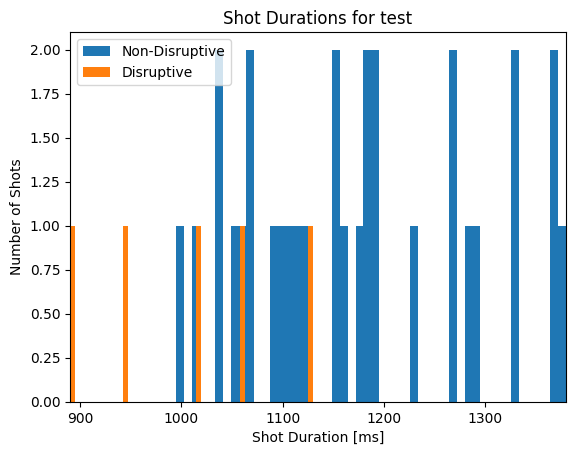

In [ ]:
plot_disruptive_vs_non_disruptive_shot_durations(experiment_list[0])